# April 14,15, 2022: Understanding stimulus of emoprox2 paradigm

In [1]:
import os
import sys
from os.path import join as pjoin

import numpy as np
import pandas as pd
import scipy as sp
import tensorflow as tf
# import tensorflow_addons as tfa
import pickle, time, random
import neural_structured_learning as nsl
from tqdm import tqdm
import json
from itertools import combinations
from operator import add

# explanation tools
import shap

# plotting
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import hypernetx as hnx
from networkx import fruchterman_reingold_layout as layout

# nilearn
from nilearn import image
from nilearn import masking
from nilearn import plotting

# main dirs
proj_dir = pjoin(os.environ['HOME'], 'explainable-ai')
results_dir = f"{proj_dir}/results"
month_dir = f"{proj_dir}/nb/mar22"

# folders
sys.path.insert(0, proj_dir)
from helpers.dataset_utils import *
from helpers.base_model import *
from helpers.model_definitions import *
from nb.apr22.ROIwise_appr_retr_timeseries_plots_helper import *

# select the GPU to be used
gpus = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    tf.config.experimental.set_memory_growth(gpus[1], True)
    tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

# print the JS visualization code to the notebook
shap.initjs()

2022-04-15 15:52:01.188430: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-04-15 15:52:03.319548: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-04-15 15:52:03.349184: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:17:00.0 name: Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 15.75GiB deviceMemoryBandwidth: 417.29GiB/s
2022-04-15 15:52:03.349464: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:65:00.0 name: Quadro RTX 5000 computeCapability: 7.5
coreClock: 1.815GHz coreCount: 48 deviceMemorySize: 15.75GiB deviceMemoryBandwidth: 417.29GiB/s
2022-04-15 15:52:03.349498: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
202

In [2]:
%%bash
proj_path="/home/govindas/vscode-BSWIFT-mnt"
main_working_path="/home/govindas/explainable-ai"
out_path="${main_working_path}/nb/apr22"
subj='002'

# 3dDeconvolve -x1D_stop \
#  -polort A \
#  -nodata 2160 1.25 \
#  -num_stimts 1 \
#  -stim_times_AM1 1 "${proj_path}/eCON/dataset/preproc2/CON${subj}/splitted_regs_fancy/CON${subj}_closeAllApprMR.txt" "dmBLOCK(1)" -stim_label 1 closeAppr \
#  -x1D ${subj}_design_mat.xmat.1D

3dDeconvolve -overwrite \
 -input "${proj_path}/eCON/dataset/preproc2/CON${subj}/func/ICA_AROMA/CON${subj}_EP_TR_MNI_2mm_SI_denoised.nii.gz" \
 -jobs 4 \
 -mask "${proj_path}/share/templates/MNI152_T1_2mm_brain_GM_02182017.nii.gz" \
 -polort A \
 -local_times \
 -concat "${proj_path}/eCON/dataset/preproc2/CON${subj}/func/runConcatInfo.1D" \
 -censor "${proj_path}/eCON/dataset/preproc2/CON${subj}/regs_fancy/CON${subj}_censor15.txt" \
 -num_stimts 2 \
 -tout \
 -stim_times_AM1 1 "${proj_path}/eCON/dataset/preproc2/CON${subj}/splitted_regs_fancy/CON${subj}_closeAllApprMR.txt" "dmBLOCK(1)"     -stim_label 1 "closeAppr" \
 -stim_times_AM1 2 "${proj_path}/eCON/dataset/preproc2/CON${subj}/splitted_regs_fancy/CON${subj}_closeAllRetrMR.txt" "dmBLOCK(1)"     -stim_label 2 "closeRetr" \
 -ortvec "${proj_path}/eCON/dataset/preproc2/CON${subj}/func/CON${subj}_MotionPar.txt"'[1..6]'  rawMotion \
 -ortvec "${proj_path}/eCON/dataset/preproc2/CON${subj}/regs_fancy/CON${subj}_MotionParDeriv.txt"  derMotion \
 -x1D "${out_path}/subj${subj}.xmat.1D" \
 -x1D_uncensored "${out_path}/subj${subj}_uncens.xmat.1D" \
 -x1D_stop
#  -bucket /data/bswift-1/Pessoa_Lab/eCON/dataset/results_ShockCensored/CON002/controllable/splitted_regs/ApprRetr_deconv/CON002_appr_bucket.nii.gz

chmod +x "${main_working_path}/helpers/getVIF.py"
echo "${out_path}/subj${subj}.xmat.1D" | "${main_working_path}/helpers/getVIF.py" 

++ '-stim_times_AM1 1 /home/govindas/vscode-BSWIFT-mnt/eCON/dataset/preproc2/CON002/splitted_regs_fancy/CON002_closeAllApprMR.txt' has 1 auxiliary values per time point
++ '-stim_times_AM1 1': basis function model 'dmBLOCK(1)' uses 1 parameters,
    out of the 1 found in timing file '/home/govindas/vscode-BSWIFT-mnt/eCON/dataset/preproc2/CON002/splitted_regs_fancy/CON002_closeAllApprMR.txt'
++ '-stim_times_AM1 2 /home/govindas/vscode-BSWIFT-mnt/eCON/dataset/preproc2/CON002/splitted_regs_fancy/CON002_closeAllRetrMR.txt' has 1 auxiliary values per time point
++ '-stim_times_AM1 2': basis function model 'dmBLOCK(1)' uses 1 parameters,
    out of the 1 found in timing file '/home/govindas/vscode-BSWIFT-mnt/eCON/dataset/preproc2/CON002/splitted_regs_fancy/CON002_closeAllRetrMR.txt'
++ No '-bucket' option given ==> using '-bucket Decon'
++ 3dDeconvolve extending num_stimts from 2 to 14 due to -ortvec
++ 3dDeconvolve: AFNI version=AFNI_20.2.18 (Sep 17 2020) [64-bit]
++ Authored by: B. Douglas

Calculating VIF for /home/govindas/explainable-ai/nb/apr22/subj002.xmat.1D
Max VIF is 1.060166


In [3]:
subj = '002'
fpath = f"{proj_dir}/nb/apr22/subj{subj}_uncens.xmat.1D"

rawCols = open(fpath, 'r').readlines()[3].split('"')[1].split(';')
rawCols = [i.strip() for i in rawCols]
# using only regressors of interest
# removing 40 polort regressors and 6 motion regressors
useCols = [i for i in rawCols if "Run" not in i if "Motion" not in i]
# print(len(useCols), useCols)

df = pd.DataFrame(np.loadtxt(fpath), columns=rawCols)
X_variables = df[useCols]

num_blocks = 6 * 2 # 2 blocks within each run
l = len(X_variables) // (num_blocks) # window length of a block
appr_regs = [X_variables['closeAppr#0'].loc[l*run:l*(run+1)].values for run in np.arange(num_blocks)]
retr_regs = [X_variables['closeRetr#0'].loc[l*run:l*(run+1)].values for run in np.arange(num_blocks)]

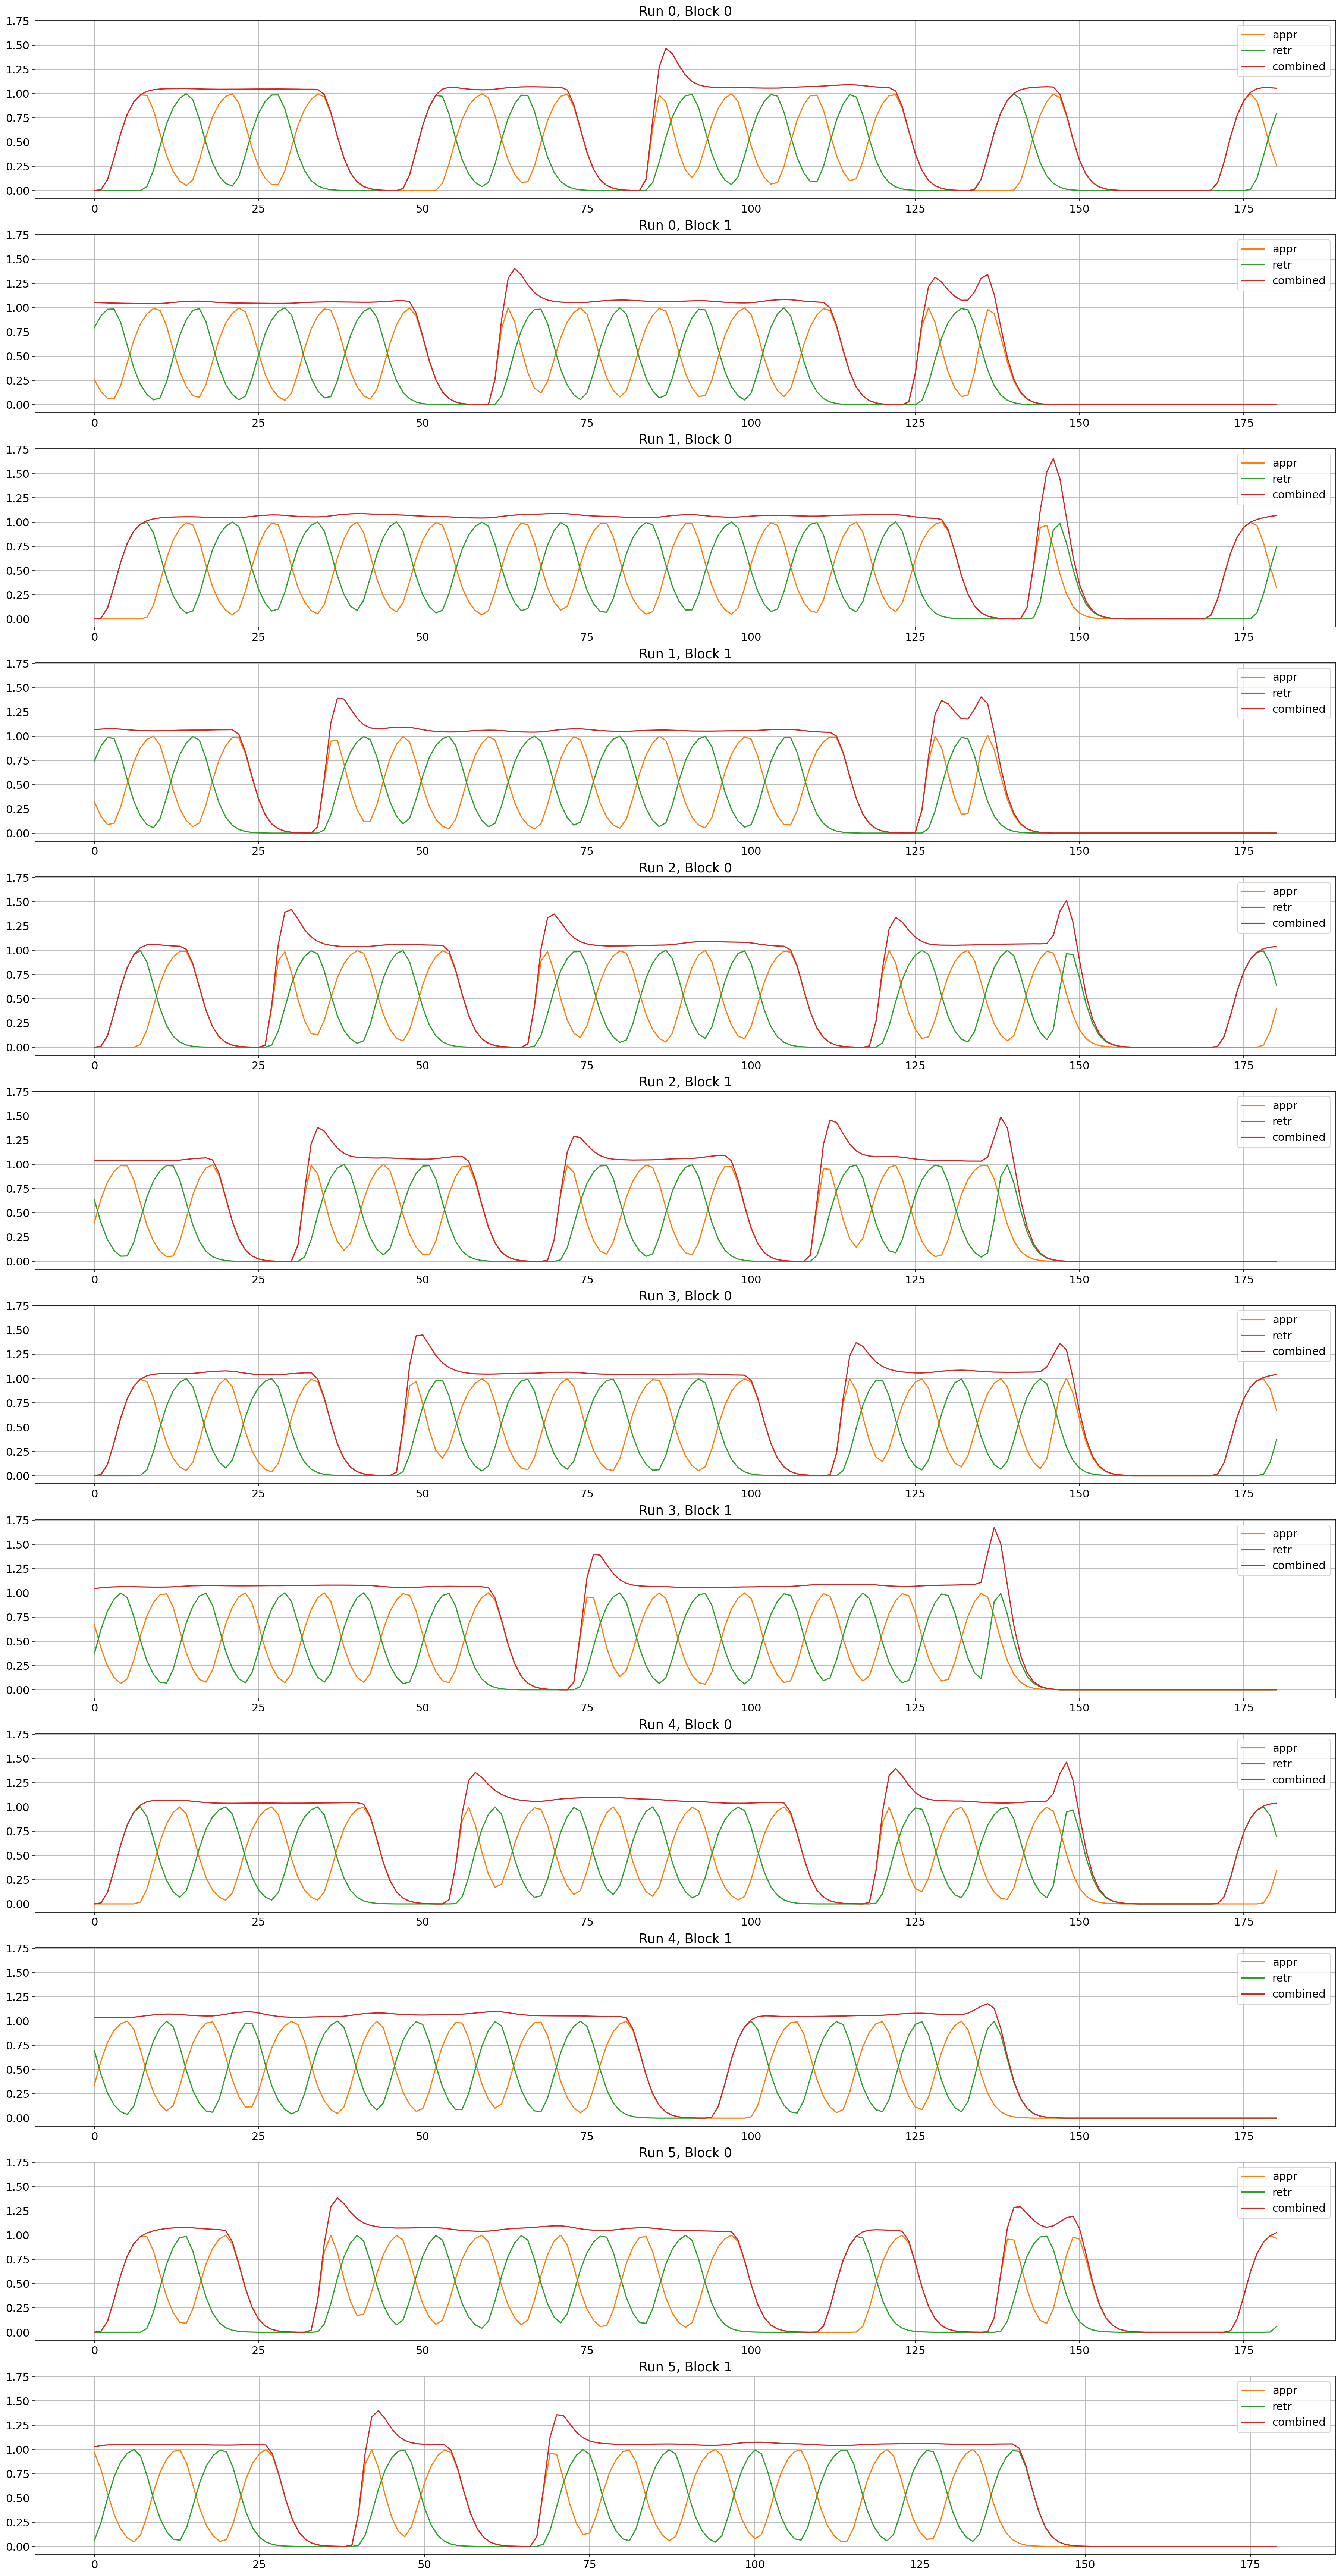

In [4]:
nrows, ncols = num_blocks, 1
figsize = (30*ncols, 5*nrows)
fig, axs = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=figsize, 
    sharex=False, 
    sharey=True, 
    dpi=150)
for idx_block in np.arange(num_blocks):
    ax = axs[idx_block]
    ax.set_title(f"Run {(idx_block)//2}, Block {idx_block%2}")
    
    # appr regressor    
    ax.plot(appr_regs[idx_block], color='tab:orange', label='appr')

    # retr regressor
    ax.plot(retr_regs[idx_block], color='tab:green', label='retr')

    # combine both regressors
    ax.plot(appr_regs[idx_block]+retr_regs[idx_block], color='tab:red', label='combined')

    ax.legend()
    ax.grid(True)